In [1]:
!pip install pytorch_lightning
!pip install pymysql
!pip install optuna

from google.colab import drive
import sys

drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/Colab Notebooks')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 44.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-man

# 데이터를 불러오기

In [2]:
import re
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import optuna
from optuna.samplers import TPESampler
import torch.nn as nn
from torch.autograd import Variable
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

def seed_everything(seed: int = 123):
    os.environ["PYTHONHASHSEED"] = str(seed)

    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(123)

meat_type = 'pork'
df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/livestock_price_data.xlsx", sheet_name='돼지_도매가격')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

forecast_horizon = 7
seq_length = forecast_horizon * 2

df = df.iloc[4:, :2]
df.columns = ['date', 'price']

In [3]:
df = pd.read_excel(
    "/content/drive/MyDrive/Colab Notebooks/livestock_price_data.xlsx",
    sheet_name='돼지_도매가격'
)

df = df.iloc[4:, :2]
df.columns = ['date', 'price']

In [4]:
df

,date,price
4,2024-04-01 00:00:00,"4,934 ▲119"
5,2024-03-29 00:00:00,"4,815 ▼53"
6,2024-03-28 00:00:00,"4,868 ▼3"
7,2024-03-27 00:00:00,"4,871 ▼21"
8,2024-03-26 00:00:00,"4,892 ▼68"
...,...,...
3296,2011-01-07 00:00:00,"4,960 ▲76"
3297,2011-01-06 00:00:00,"4,884 ▲135"
3298,2011-01-05 00:00:00,"4,749 ▼27"
3299,2011-01-04 00:00:00,"4,776 ▲137"


# 데이터를 전처리

In [5]:
def extract_trend(x):
    if re.search('▼', x):
        symbol = -1
    elif re.search('▲', x):
        symbol = 1
    else:
        return np.nan

    x = re.split('▼|▲', x)[1]
    x= re.sub(',|-| ', '', x)

    return float(x) * symbol

df['price'] = df['price'].apply(lambda x: re.split('▼|▲', x)[0] if re.search('▼|▲', x) else x)
df['price'] = df['price'].apply(lambda x: re.sub(',|-| ', '', x))
df['price'] = df['price'].apply(lambda x: float(x) if x != '' else np.nan)

df = df.sort_values('date')
df = df[['date', 'price']]
df.index = range(len(df))

data = df.loc[:, ['price']].values

In [6]:
df

,date,price
0,2011-01-03 00:00:00,4639.0
1,2011-01-04 00:00:00,4776.0
2,2011-01-05 00:00:00,4749.0
3,2011-01-06 00:00:00,4884.0
4,2011-01-07 00:00:00,4960.0
...,...,...
3292,2024-03-26 00:00:00,4892.0
3293,2024-03-27 00:00:00,4871.0
3294,2024-03-28 00:00:00,4868.0
3295,2024-03-29 00:00:00,4815.0


# 데이터 시각화

<Axes: title={'center': 'pork price'}, xlabel='date'>

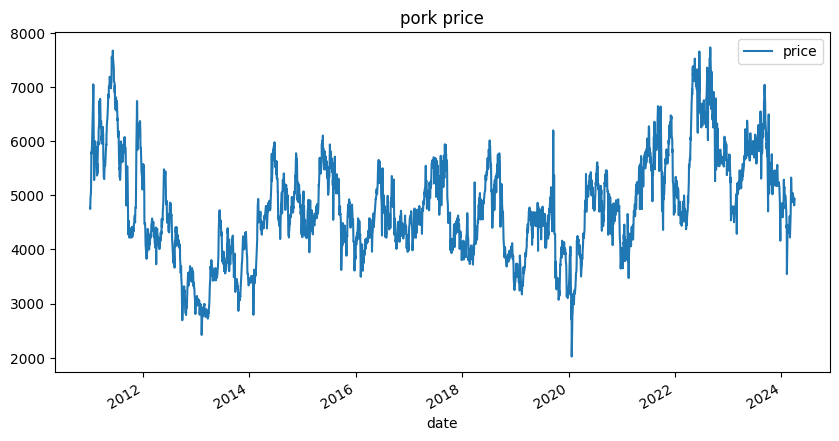

In [ ]:
df.plot(x='date', y='price', title=f'{meat_type} price', figsize=(10, 5))

# 데이터 정규화

In [ ]:
sc = MinMaxScaler()
data_scaled = sc.fit_transform(data)

In [ ]:
data

array([[4776.],
       [4749.],
       [4884.],
       ...,
       [4868.],
       [4815.],
       [4934.]])

In [ ]:
data_scaled

array([[0.48214911],
       [0.47742387],
       [0.50105005],
       ...,
       [0.49824991],
       [0.48897445],
       [0.50980049]])

# sliding window를 이용하여 데이터를 만들기

In [ ]:
def sliding_windows(data, seq_length, forecast_horizon):
    x = []
    y = []

    for i in range(len(data)-seq_length-forecast_horizon):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length+forecast_horizon-1]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

# 데이터 나누기

In [ ]:
train_size = int(data_scaled.shape[0] * 0.8)
test_size = data_scaled.shape[0] - train_size

print(f'train_size: {train_size}, test_size: {test_size}')

train_data_scaled = data_scaled[:train_size]
test_data_scaled = data_scaled[train_size-forecast_horizon:]

trainX, trainY = sliding_windows(train_data_scaled, seq_length, forecast_horizon)
testX, testY = sliding_windows(test_data_scaled, seq_length, forecast_horizon)

trainX = Variable(torch.Tensor(trainX))
trainY = Variable(torch.Tensor(trainY))
testX = Variable(torch.Tensor(testX))
testY = Variable(torch.Tensor(testY))

train_size: 2624, test_size: 656


# LSTM 모델 구축

In [ ]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device)
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device)

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))

        # h_out = h_out.view(-1, self.hidden_size)
        h_out = h_out[-1]

        out = self.fc(h_out)

        return out

# Hyperparamter tuning

In [ ]:
input_size = 1
num_classes = 1

def objective(trial):
    hidden_size = trial.suggest_int('hidden_size', 2, 10)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)

    lstm = LSTM(num_classes, input_size, hidden_size, num_layers).to(device)
    criterion = torch.nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

    for epoch in range(2000):
        outputs = lstm(trainX.to(device))
        optimizer.zero_grad()
        loss = criterion(outputs, trainY.to(device))
        loss.backward()
        optimizer.step()

    # Evaluate the model on the validation set
    val_outputs = lstm(testX.to(device))
    val_loss = criterion(val_outputs, testY.to(device))

    return val_loss.item()

study = optuna.create_study(direction="minimize", sampler=TPESampler(seed=123))
study.optimize(objective, n_trials=20)

[I 2024-05-20 09:22:34,870] A new study created in memory with name: no-name-89d0aab4-6a03-40a5-a541-023adad8a920
<ipython-input-14-397b311c3f3c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
[I 2024-05-20 09:24:20,869] Trial 0 finished with value: 0.04170362651348114 and parameters: {'hidden_size': 8, 'num_layers': 1, 'learning_rate': 8.079896808319467e-05}. Best is trial 0 with value: 0.04170362651348114.
<ipython-input-14-397b311c3f3c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
[I 2024-05-20 09:33:27,063] Trial 1 finishe

# LSTM 모델 생성

In [ ]:
best_params = study.best_params
best_loss = study.best_value

print("Best Parameters:", best_params)
print("Best Loss:", best_loss)

hidden_size = best_params['hidden_size']
num_layers = best_params['num_layers']
learning_rate = best_params['learning_rate']
num_epochs = 2000

lstm = LSTM(num_classes, input_size, hidden_size, num_layers).to(device)

In [ ]:
criterion = torch.nn.MSELoss().to(device) # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX.to(device))
    optimizer.zero_grad()

    # obtain the loss function
    loss = criterion(outputs, trainY.to(device))

    loss.backward()

    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

# 학습된 LSTM 모델로 예측 및 예측결과 시각화

In [ ]:
lstm.eval()
train_predict = lstm(trainX.to(device))
test_predict = lstm(testX.to(device))

train_predict = train_predict.cpu().data.numpy()
test_predict = test_predict.cpu().data.numpy()

train_predict = sc.inverse_transform(train_predict)
test_predict = sc.inverse_transform(test_predict)

trainY_inv = sc.inverse_transform(trainY)
testY_inv = sc.inverse_transform(testY)

In [ ]:
data_predict = np.vstack([train_predict, test_predict])
dataY_plot = np.vstack([trainY_inv, testY_inv])

fig = plt.figure(figsize=(15, 5))
plt.axvline(x=len(trainX), c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

# LSTM 모델 성능 평가

In [ ]:
print("=> 학습데이터 성능평가:")
print('Train RMSE:', round(np.sqrt(mean_squared_error(trainY_inv, train_predict)), 2))
print('Train MAPE:', round(mean_absolute_percentage_error(trainY_inv, train_predict), 2))

print("\n=> 테스트데이터 성능평가:")
print('Test RMSE:', round(np.sqrt(mean_squared_error(testY_inv, test_predict)), 2))
print('Test MAPE:', round(mean_absolute_percentage_error(testY_inv, test_predict), 2))